## Solving Path Finding in a Grid using A* Search

##### Pathfinding in a grid-based environment is a common problem in AI, often used in games and robotics to find the shortest path from a start point to a goal point while avoiding obstacles. In my case, I'm using it to simulate a game where an agent traverses through an obstacle grid from the start to the goal state via the most optimal and shortest route. The A* algorithm is an effective solution for this problem because it combines the strengths of Dijkstra's Algorithm and Greedy Best-First Search to efficiently find the optimal path. 

Problem Representation
1. The environment is represented as a grid where each cell is a node.
2. Nodes are connected by edges, with each edge having a weight that represents the cost of moving between two nodes.
3. The grid may contain obstacles, which are cells that cannot be traversed. They are modelled by removing nodes.

Main Steps of the Solution Approach
1. Define the grid by taking user input for the grid size and the number of obstacles needed.
2. Ask the user the required start and goal state.
3. Find the best path by using the A* algorithm.
4. Visualizing the grid space of the particular problem and highlighting the path taken by the agent if a path exists.

Main Steps in A* Algorithm
1. Initialization:
   A set is initialized to store visited states. 
   A priority queue (a heap) is initialized as the frontier with a tuple of start node and the path to it (a list), and the priority value to explore nodes. 

2. Exploration and path finding: 
   Iteratively pops the node with highest priority (lowest estimated cost)
   Then checks whether it is the goal state, returns the path if it is, if not continues to check whether it is in the visited set, if it is there, continues to the next iteration and does the same checks to the next highest priority state.
   Adds to the visited set if it isn't there. Then iterates through each neighbor state to check if they are in visited set. If not, the priority is calculated and it is pushed to the frontier. 
   The process continues until the goal is found or frontier is empty.

In [1]:
import heapq    #provides procedures of a heap queue (priority queue)
import numpy as np    #for effeicient mathematical operations
import networkx as nx   #library to create weighted graphs
import matplotlib.pyplot as plt  #for visualizing and plotting paths

In [2]:
def make_grid(grid_size, num_obstacles):
    """Returns a weighted grid graph, its obstacles and simulate the game"""
    #creates a square grid graph where each node is a cell and edges represent possible moves
    G = nx.grid_2d_graph(grid_size, grid_size) 

    #adding weights to the edges
    for (_, _, weight_dic) in G.edges(data=True):  #edges(data=True) returns a tuple with 3 elements --> 2 edges (not needed here hence the _ placeholder) and adictionary of the weight of their edge
        #assigning random weights between 1 and 10 to simulate different movement costs 
        weight_dic['weight'] = np.random.randint(1,10)  

    obstacles = []
    for _ in range(num_obstacles): 
         #randomly create obstacles within the grid 
        obstacles.append((np.random.randint(0,grid_size), np.random.randint(0,grid_size))) 

    #creating obstacles by removing nodes
    G.remove_nodes_from(obstacles) 
    #return both the graph and the obstacles list
    return G, obstacles 

In [3]:
#Defining a priority queue class to use as the frontier for the A* algorithm
#heapq module provides implementations to develop a priority queue

class Priority_queue:
    def __init__(self):
        self._heap = []

    def push(self, item, priority):
        """
        Add an item to the priority queue with the given priority.

        Parameters:
            item: The item to add to the queue.
            priority: The priority of the item. Lower numbers indicate higher priority.
        """
        heapq.heappush(self._heap, (priority, item))

    def pop(self):
        """
        Remove and return the item with the highest priority (lowest priority number).

        Returns:
            The item with the highest priority.

        Raises:
            IndexError: If the priority queue is empty.
        """
        if self.is_empty():
            raise IndexError("pop from an empty priority queue")
        return heapq.heappop(self._heap)[1]

    def peek(self):
        """
        Return the item with the highest priority without removing it.

        Returns:
            The item with the highest priority.

        Raises:
            IndexError: If the priority queue is empty.
        """
        if self.is_empty():
            raise IndexError("peek from an empty priority queue")
        return self._heap[0][1]

    def is_empty(self):
        """
        Check if the priority queue is empty.

        Returns:
            True if the priority queue is empty, False otherwise.
        """
        return len(self._heap) == 0

    def __len__(self):
        """
        Return the number of items in the priority queue.

        Returns:
            The number of items in the queue.
        """
        return len(self._heap)


In [4]:
#defining a weighted heuristic of the algorithm 
#reference - https://www.sciencedirect.com/science/article/pii/S0004370215000545
def heuristic(state, goal_state, max_cost):   #the parameters state and goal_state are coordinates (a tuple) of those states 
    """Returns a consistent heuristic using euclidean distance""" 
    return max_cost*np.sqrt(sum((a-b)**2 for a,b in zip(state, goal_state))) #multiplication by a weight (in this case the maximum cost), makes sure that the heuristic is consistent always

In [5]:
#Defining the A* algorithm
def A_Star(G, start, goal):
    """Defines the functioning of the A* algorithm and returns the most optimal, shortest path from start to goal or None"""
    #store visited states
    visited = set()   
    #store states to be expanded
    frontier = Priority_queue() 
    #pushing the root node along with the path and its priority
    frontier.push((start, [start]),0)  

    #Calculate the maximum edge weight in the graph to use in the heuristic
    max_cost = max(d_weights['weight'] for _,_, d_weights in G.edges(data=True))

    while not(frontier.is_empty()):  #loops until the frontier is empty
        #pops the item with highest priority
        (state, path) = frontier.pop() 

        if state == goal:
            return path  #return path if goal is reached

        if state in visited:
            continue    #skip to next iteration (state) if node has already been visited
        visited.add(state)

        #explore each neighbour nodes
        for neighbor in G.neighbors(state):  #G.neighbours(x) gives an iterator over all neighbours of x
            if neighbor in visited:
                continue
            #calc the priority value and push it into the frontier
            new_cost = nx.path_weight(G, path, weight='weight') + G[state][neighbor]['weight'] #path cost from start to current state (state) + current state (state) to its neighbor
            priority = new_cost + heuristic(neighbor, goal, max_cost) #f(n) = g(n) + h(n)
            frontier.push((neighbor, path+[neighbor]), priority)

    return None  #if no path is found

In [6]:
#start and goal states are asked by the user
def get_coordinates(obstacles, prompt, grid_size): #obstacles list is passed in to check if the user enters an obstacle coordinate
    """Asks the user to enter coordinates as comma seperated integers between 0 and grid_size-1"""
    while True:
        try:
            #prompts the user
            coords = input(prompt) 
            #split the string at the comma and apply the int() function to the strings to convert into ints
            x,y = map(int, coords.split(','))  

            #validating whether the user input is within valid range and is not an intially removed state (as an obstacle)
            if 0<=x<grid_size and 0<=y<grid_size and (x,y) not in obstacles: 
                return (x,y)
            else:
                print(f"\nInput Err: Coordinates are out of range. Enter integers between 0 and {grid_size-1}")
        except ValueError:
            print("\nInvalid input. Enter coordinates such as x,y where x,y belong to integers")

In [7]:
#Visualization
def visualizing_path(G, path, start, goal):
    """Visualizing the optimal, shortest path taken by the agent"""
    plt.figure(figsize=(20,20))
    positions = {node: node for node in G.nodes()}  #{(0,0):(0,0), (0,1):(0,1)....} nx.draw() uses this var to map these keys to nodes and their values to corresponding positions
    
    #simple graph- no node labels or edge labels
    nx.draw(G, pos=positions, with_labels=True, node_color='yellow', linewidths=9) 
    #draw edge labels
    nx.draw_networkx_edge_labels(G, pos=positions, edge_labels={(edge1, edge2): str(dict_weights['weight']) for edge1, edge2, dict_weights in G.edges(data=True)}, font_size=25, rotate=False, alpha=0.999) 
    
    #highlighting the path
    if path: #if a path exists
        #gives a list of tuples containing nodes of corresponding edges of the path taken
        path_edges = list(zip(path, path[1:])) 
        #coloring edges of the path in blue
        nx.draw_networkx_edges(G, pos=positions, edgelist=path_edges, edge_color='blue', width=2)  
        #color nodes in dark orange
        nx.draw_networkx_nodes(G, pos=positions, nodelist=path, node_color='darkorange', node_shape='o', node_size=600) 
        #color start node in red
        nx.draw_networkx_nodes(G, pos=positions, nodelist=[start], node_color='red', node_shape='o', node_size=600) 
        #color goal node in green
        nx.draw_networkx_nodes(G, pos=positions, nodelist=[goal], node_color='lightgreen', node_shape='o', node_size=600) 

        plt.grid(True)
        plt.show()

    else:
        print("\nNo path found master Thiviru... I'm lost! ):")

In [8]:
def main():
    """Execution of the solution"""
    #user input for grid size (one side length)
    grid_size = int(input("What is the grid size? (Enter a single integer) ---> ")) 

    #looping until a valid integer is entered to ensure smooth working
    while True:  
        try:
            num_obstacles = int(input("How many obstacles do you need? ---> "))

            #checking if the number of obstacles are not exceeding the total number of nodes in the graph
            if 0<=num_obstacles<=grid_size**2: 
                break
            else:
                print(f"\nPlease enter a number between 0 and {grid_size**2}")
        except ValueError:
            print("\nInvalid input. Please enter an integer.")

    #making the grid
    grid, obstacles = make_grid(grid_size=grid_size, num_obstacles=num_obstacles) 
    #start state user input
    start_state = get_coordinates(prompt="Enter Start state coordinates ---> ", grid_size=grid_size, obstacles=obstacles) 
    #goal state user input
    goal_state = get_coordinates(prompt="Enter Goal state coordinates ---> ", grid_size=grid_size, obstacles=obstacles)

    #find shortest path between start and goal states
    path = A_Star(G=grid, start=start_state, goal=goal_state) 
    
    #visualizing the path taken by the agent
    visualizing_path(G=grid, path=path, start=start_state, goal=goal_state)

    #to make sure to run only if a path exists
    if path:
        print("----------- I've succeeded master Thiviru!! -----------")
        print(f"\nStart Coordinates -> {start_state}\nGoal Coordinates -> {goal_state}\n\nPath --> {path}")

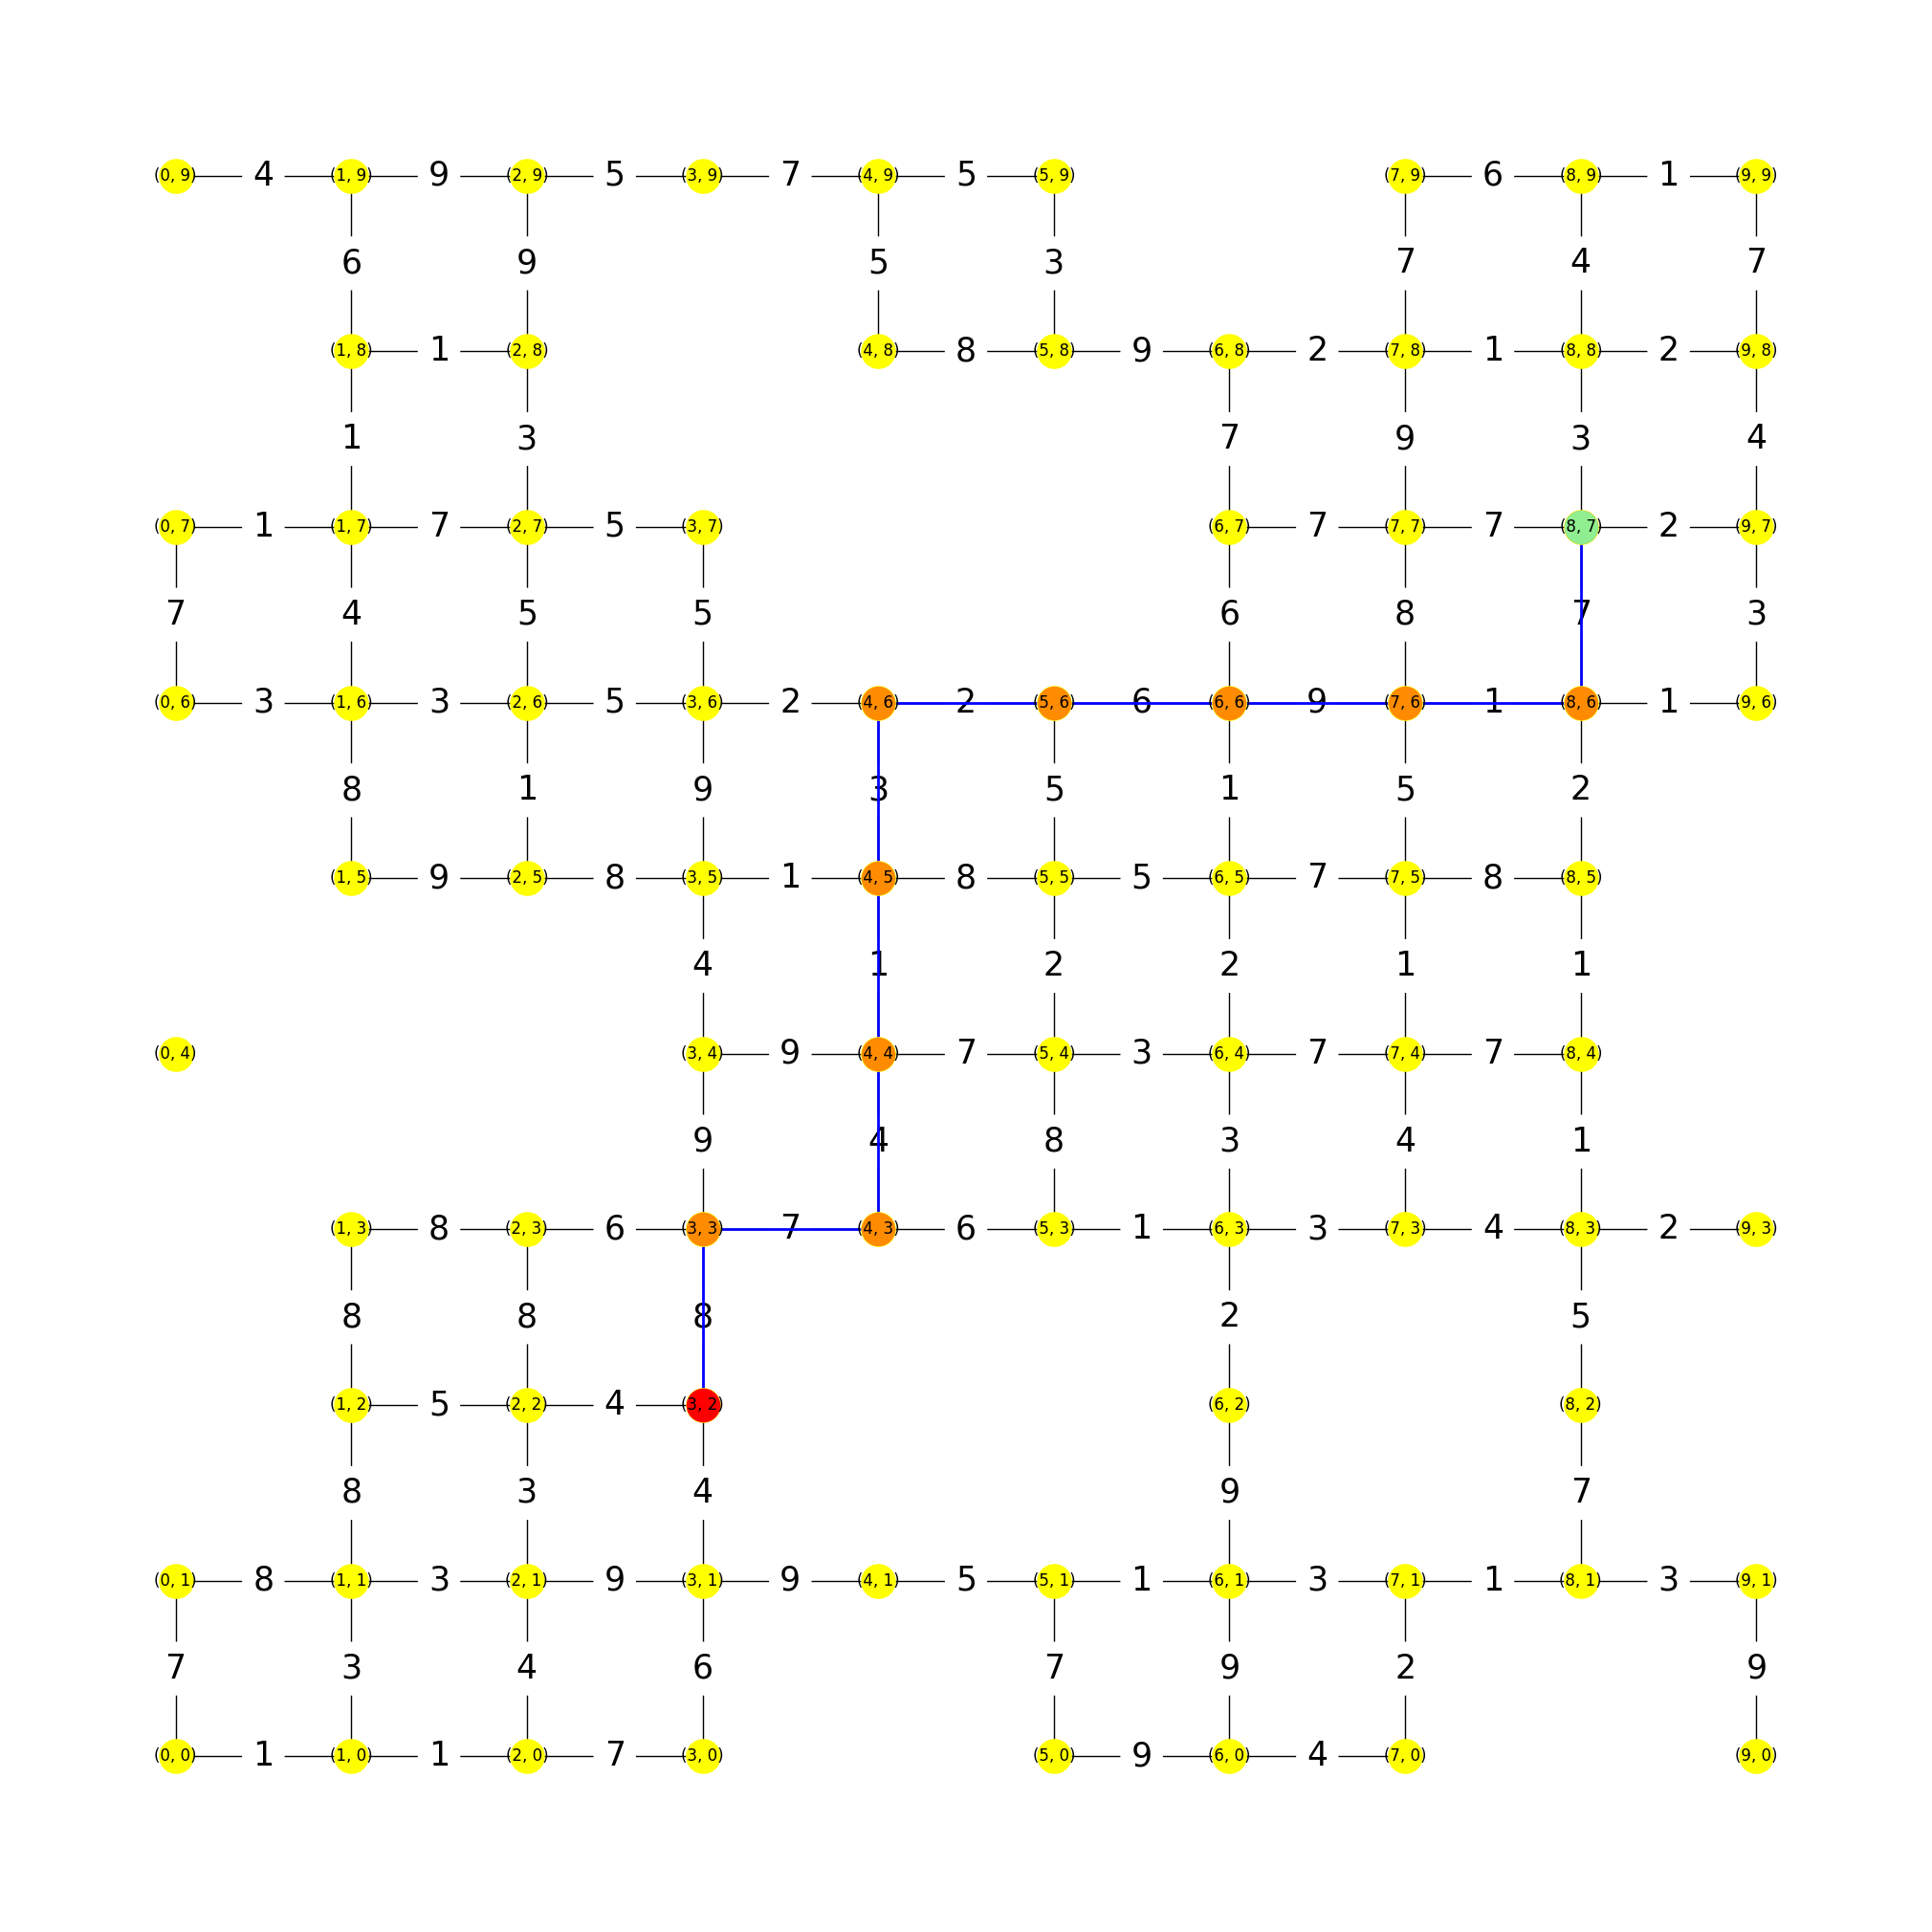

----------- I've succeeded master Thiviru!! -----------

Start Coordinates -> (3, 2)
Goal Coordinates -> (8, 7)

Path --> [(3, 2), (3, 3), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (8, 7)]


In [10]:
main()